In [ ]:
#Self-Taught Learning and Unsupervised Feature Learning

In [1]:
import scipy.io as scpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn import metrics
from sklearn import tree
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.grid_search import GridSearchCV
from sklearn import svm
from sklearn.manifold import TSNE
import scipy.optimize as opt
import glob
import sys
import os
import theano.tensor as T
from theano import function
from theano import shared
import theano
from theano.tensor.signal import downsample
from theano.tensor.nnet import conv

#np.random.seed(1337)  # for reproducibility
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.models import Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Layer, Reshape, Merge #,AutoEncoder
from keras.layers.convolutional import Convolution2D,MaxPooling2D,Convolution1D,MaxPooling1D,UpSampling2D, ZeroPadding2D
from keras.optimizers import SGD, Adam, RMSprop, Adadelta
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
#import keras.utils.visualize_util as vutil #Pydot issues
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.regularizers import l1, l2, l1l2, activity_l2, activity_l1
#import keras.layers.containers as containers  #No module named containers
from keras.layers.noise import GaussianNoise
from keras.regularizers import ActivityRegularizer
from keras import backend as K
#import keras.utils.visualize_util as vutil
from keras.models import model_from_json
#from keras.utils.visualize_util import plot, to_graph

from IPython.display import SVG

np.set_printoptions(suppress=True)  #Supress exponent of the number 2e-2 == 0.02

import load_MNIST
import numpy as np
import sparse_autoencoder
import scipy.optimize
import display_network
import softmax


%matplotlib inline
print("All imports done")


#Ref: http://deeplearning.net/, https://www.kaggle.com/wiki/Tutorials etc..

#caso_I.mat, caso_II.mat, caso_III.mat, caso_base.mat, consumer_data.xlsx

#print(os.getcwd() + "\n")
#print os.listdir(os.getcwd())
dataSmartGrid = scpy.loadmat('/home/rbhat/Workspace/S3Lab_Projects/Deep-SmartGrid/demcliMat.mat')
print type(dataSmartGrid)

data = dataSmartGrid['demcliMat']
print data.shape
print data
print("Example:")
print data[1]

np.unique(data[:,-1:])

X = data[:,0:-1]
Y = data[:,-1]

print X.shape, Y.shape

#print X.shape
Y1 = Y
Y1[Y1==2] = 1
print Y1.shape

np.unique(Y1)

#print data[0:5,:]
#print data[0:5,0:-1]
#print data[0:5,-1]


#print X
#print Y
#Splitting data into train and testing. 70% Training and 30% Testing..
X_train, X_test, y_train, y_test = train_test_split(X, Y1, test_size=0.3, random_state=4)

print X_train.shape, y_train.shape, X_test.shape, y_test.shape
#print numpy.unique(Y_test)

X_train_1 = X_train.reshape(8526,12,1)
X_test_1 = X_test.reshape(3654,12,1)

print X_train_1.shape, X_test_1.shape 

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, 2)
Y_test = np_utils.to_categorical(y_test, 2)

Y_train = Y_train.astype('int')
Y_test = Y_test.astype('int')

print("Sets made")

rms = RMSprop()


ERROR (theano.sandbox.cuda): nvcc compiler not found on $PATH. Check your nvcc installation and try again.
ERROR:theano.sandbox.cuda:nvcc compiler not found on $PATH. Check your nvcc installation and try again.


All imports done
<type 'dict'>
(12180, 13)
[[ 343.33881535  292.94608369  317.56346931 ...,    0.            0.            2.        ]
 [ 229.55690517  183.19172676    0.         ...,    0.            0.            2.        ]
 [ 106.98249046   79.89465389   60.93378272 ...,   50.91543646
    44.87156581    1.        ]
 ..., 
 [ 232.28249497  135.43054     200.91859872 ...,  187.78214091
   191.41443704    0.        ]
 [ 239.19601078  206.37272444  174.6964434  ...,  297.67230497
   202.62736538    0.        ]
 [ 277.38010202  209.01016123  277.00169283 ...,  146.70298371
   309.63963308    0.        ]]
Example:
[ 229.55690517  183.19172676    0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    2.        ]
(12180, 12) (12180,)
(12180,)
(8526, 12) (8526,) (3654, 12) (3654,)
(8526, 12, 1) (3654, 12, 1)
(8526, 'train samples')
(3654, 'test samples')
Sets made


/usr/local/lib/python2.7/dist-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")
Using Theano backend.


In [2]:
input_size = 12
num_labels = 2
hidden_size = 196

tot_iter = 400

sparsity_param = 0.1  # desired average activation of the hidden units.
lambda_ = 3e-3  # weight decay parameter
beta = 3  # weight of sparsity penalty term

#Unlabelled Data

X_train_new = np.transpose(X_train)
X_test_new  = np.transpose(X_test)

unlabeled_data = X_train_new[ : , 4263:8525]


#Labelled Data
train_data = X_train_new[ : , 0:4262]
train_labels = y_train[0:4262]

test_data = X_test_new
test_labels = y_test

print '# examples in unlabeled set: {0:d}\n'.format(unlabeled_data.shape[1])
print '# examples in supervised training set: {0:d}\n'.format(train_data.shape[1])
print '# examples in supervised testing set: {0:d}\n'.format(test_data.shape[1])


# examples in unlabeled set: 4262

# examples in supervised training set: 4262

# examples in supervised testing set: 3654



In [3]:
## ======================================================================
#  STEP 2: Train the sparse autoencoder
#  This trains the sparse autoencoder on the unlabeled training
#  images.

#  Randomly initialize the parameters
theta = sparse_autoencoder.initialize(hidden_size, input_size)

J = lambda x: sparse_autoencoder.sparse_autoencoder_cost(x, input_size, hidden_size,
                                                         lambda_, sparsity_param,
                                                         beta, unlabeled_data)

options_ = {'maxiter': tot_iter, 'disp': True} #Was 400
result = scipy.optimize.minimize(J, theta, method='L-BFGS-B', jac=True, options=options_)
opt_theta = result.x

print result

  status: 0
 success: True
    nfev: 458
     fun: 366285.4368353716
       x: array([-1.59064336, -1.49649353, -1.11331628, ...,  4.62476761,
        4.90832128,  5.00598477])
 message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     jac: array([-0.00477193, -0.00448948, -0.00333995, ..., -0.04583577,
       -0.04047647, -0.03576004])
     nit: 349


In [4]:
# Visualize the weights
W1 = opt_theta[0:hidden_size * input_size].reshape(hidden_size, input_size).transpose()
#display_network.display_network(W1,filename='STL_Weights.png')

##======================================================================
## STEP 3: Extract Features from the Supervised Dataset
#
#  Train on labeled set using unlabeled weights.
#  

train_features = sparse_autoencoder.sparse_autoencoder(opt_theta, hidden_size,
                                                       input_size, train_data)

test_features = sparse_autoencoder.sparse_autoencoder(opt_theta, hidden_size,
                                                      input_size, test_data)

In [5]:
##======================================================================
## STEP 4: Train the softmax classifier

lambda_ = 1e-4
options_ = {'maxiter': tot_iter, 'disp': True}

opt_theta, input_size, num_classes = softmax.softmax_train(hidden_size, num_labels,
                                                           lambda_, train_features,
                                                           train_labels, options_)

  status: 0
 success: True
    nfev: 251
     fun: 685.75929010055222
       x: array([-0.16397887,  0.50972857, -0.16056797, -0.15827942, -0.53709237,
       -0.14531182, -0.1637121 ,  0.46070658, -0.15075828, -0.16090846,
       -0.15859434, -0.16073675, -0.74232003, -0.15994617, -0.09761587,
       -0.96985818, -0.15539252, -0.13866354, -5.01936221, -0.38713982,
        0.03338288, -0.16291524,  0.49307587,  0.00571932,  0.2434708 ,
       -0.51527062,  0.17560285, -0.156486  , -0.15210426, -0.12044086,
        0.01942299, -0.14826068, -0.16240654, -0.15822431, -0.64298973,
        0.10954248, -0.26912841,  0.02851993,  0.16709771,  0.42096949,
       -0.1589995 , -0.76371318, -0.15846923, -0.15713617,  0.48401345,
       -0.15205344, -0.15806945, -0.17274667,  0.60707117, -0.15676691,
       -0.15432164, -0.15362029, -3.45014656, -0.39064296,  0.3465896 ,
        0.22995386,  0.04364837,  0.32409825, -0.09773282, -0.15933188,
       -0.44966599, -0.15954318,  0.11501755, -0.9097227

In [10]:
##======================================================================
## STEP 5: Testing

predictions, pred_prob = softmax.softmax_predict((opt_theta, input_size, num_classes), test_features)
print "Accuracy: {0:.2f}%".format(100 * np.sum(predictions == test_labels, dtype=np.float64) / test_labels.shape[0])

Accuracy: 94.94%


In [11]:
pred_prob.shape

(3654, 2)

In [12]:
Y_preds_sae = predictions
conf = metrics.confusion_matrix(y_test,Y_preds_sae)
print(conf)

[[3318   84]
 [ 101  151]]


In [13]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, Y_preds_sae, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.97      0.98      0.97      3402
    class 1       0.64      0.60      0.62       252

avg / total       0.95      0.95      0.95      3654



In [15]:
np.sum(Y_preds_sae==1)

235

In [16]:
pred_prob

array([[ 0.96868244,  0.03131756],
       [ 0.96235483,  0.03764517],
       [ 0.98740001,  0.01259999],
       ..., 
       [ 0.94299153,  0.05700847],
       [ 0.99951257,  0.00048743],
       [ 0.99797109,  0.00202891]])

[[ 0.96868244  0.03131756]
 [ 0.96235483  0.03764517]
 [ 0.98740001  0.01259999]
 [ 0.99904941  0.00095059]
 [ 0.88018202  0.11981798]]


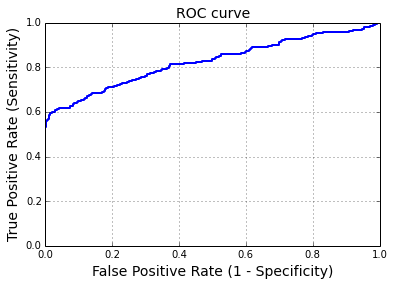

In [21]:
Y_preds_prob_sae = pred_prob#model.predict_proba(X_test_1, verbose=0)
print(Y_preds_prob_sae[:5])




#ROC curve
# IMPORTANT: first argument is true values, second argument is predicted probabilities
fpr1, tpr1, thresholds = metrics.roc_curve(y_test, Y_preds_prob_sae[:,1])
plt.plot(fpr1, tpr1, lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve',fontsize=14)
plt.xlabel('False Positive Rate (1 - Specificity)',fontsize=14) #fontweight='bold'
plt.ylabel('True Positive Rate (Sensitivity)',fontsize=14)
plt.grid(True)

#plt.savefig('smartgrid_sae_roc.png')

#Y_logPred_prob = logReg.predict_proba(X_test)[:, 1]

In [22]:
print metrics.roc_auc_score(y_test, Y_preds_prob_sae[:,1])

0.824117232627


In [ ]:
DO NOT RUN DO NOT RUN DO NOT RUN DO NOT RUN

import load_MNIST
import numpy as np
import sparse_autoencoder
import scipy.optimize
import display_network
import softmax

## ======================================================================
#  STEP 0: Here we provide the relevant parameters values that will
#  allow your sparse autoencoder to get good filters;

input_size = 28 * 28
num_labels = 5
hidden_size = 196

sparsity_param = 0.1  # desired average activation of the hidden units.
lambda_ = 3e-3  # weight decay parameter
beta = 3  # weight of sparsity penalty term

## ======================================================================
#  STEP 1: Load data from the MNIST database
#
#  This loads our training and test data from the MNIST database files.
#  

images = load_MNIST.load_MNIST_images('train-images-idx3-ubyte')
labels = load_MNIST.load_MNIST_labels('train-labels-idx1-ubyte')

unlabeled_index = np.argwhere(labels >= 5).flatten()  #5,6,7,8,9,10 unlabeled
labeled_index = np.argwhere(labels < 5).flatten()     #0,1,2,3,4 labeled

num_train = round(labeled_index.shape[0] / 2)
train_index = labeled_index[0:num_train]
test_index = labeled_index[num_train:]

unlabeled_data = images[:, unlabeled_index]

train_data = images[:, train_index]
train_labels = labels[train_index]

test_data = images[:, test_index]
test_labels = labels[test_index]

print '# examples in unlabeled set: {0:d}\n'.format(unlabeled_data.shape[1])
print '# examples in supervised training set: {0:d}\n'.format(train_data.shape[1])
print '# examples in supervised testing set: {0:d}\n'.format(test_data.shape[1])